## Master's Thesis: In-process defect monitoring Using Computer Vision for FDM Additive Manufacturing

#  Setup and depedependency

This project demonstrates the process of finel fine-tuning the YOLOv11 object detection model on a FDM printer dataset using the Ultralytics library and Roboflow for data management. The project involves setting up the Colab environment, installing necessary libraries, preparing the dataset, training the model, and evaluating its performance.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Jan 25 17:11:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. The following command allows you to create a temporary "content" folder in Colab.

In [ ]:
# Import the 'os' module to interact with the operating system
import os

# Get the current working directory and assign it to the variable 'HOME'
HOME = os.getcwd()

# Print the current working directory to verify where the code is being executed from
print(HOME)


/content


## Install YOLO11 via Ultralytics

This command installs the necessary libraries—Ultralytics (for YOLO models), Supervision, and Roboflow—in Google Colab. The `ultralytics.checks()` function verifies the installation and dependencies to ensure everything is set up correctly. ( If successful, it will show to: Setup Complete)

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 31.0/235.7 GB disk)


## Setup of Our FDM Anomalies Anotation Dataset.  

Here, we use the Roboflow API to fetch data directly from my private dataset. Please do not share this key.

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. Here is the data structured.  In data.yaml also cross check with class which look like :

train: ../train/images

val: ../valid/images

test: ../test/images

nc: 4
names: ['DEFECT- Cracks', 'DEFECT- Layer-shift', 'DEFECT- Spaghetti', 'DEFECT- Stringging']

datasets/  
│── train/  
│   ├── images/  
│   ├── labels/  
│── valid/  
│   ├── images/  
│   ├── labels/  
│── test/  
│   ├── images/  
│   ├── labels/  
│── data.yaml  


In [ ]:
# Create a directory named 'datasets' in the home directory to store dataset files
!mkdir {HOME}/datasets

# Change the current working directory to the newly created 'datasets' folder
%cd {HOME}/datasets

# Import the 'userdata' module from Google Colab (though not used here)
from google.colab import userdata

# Import the Roboflow library, which is used for dataset management, model training, and deployment
from roboflow import Roboflow

# Install the Roboflow package, which provides functionality for interacting with the Roboflow API
!pip install roboflow


from roboflow import Roboflow

# Initialize the My Roboflow Dataset with My API key
rf = Roboflow(api_key="shYVCPhods7mU9FnXRhh")

#Access a specific project in the 'secondaccount' workspace and the 'project-11.2-mbg' project
project = rf.workspace("second-account").project("project-11.2-acmbg")

#Below is just specific folder and project of my Roboflow
version = project.version(2)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Project-11.2-2 in yolov11:: 100%|██████████| 21016/21016 [00:02<00:00, 8365.19it/s]


## To Start Training On Our Dataset.

In [ ]:
# Change the current working directory to the 'HOME' directory
%cd {HOME}

# Run YOLO training with the specified parameters


!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml \
epochs=130 batch=64 imgsz=640 plots=True \



#The hyperparameters listed below are the best, as they have been optimized through experiments conducted on our FDM printer dataset.

lr0=0.0018 \                 # Initial learning rate
optimizer=adamw \            # Optimizer type (AdamW)
weight_decay=0.0004 \        # Weight decay to prevent overfitting
momentum=0.85 \              # Momentum factor
lrf=0.009 \                  # Learning rate scheduler factor
mosaic=1.0 \                 # Mosaic augmentation (mixing random images)
mixup=0.2 \                  # Mixup augmentation (blending images)
warmup_epochs=4             # Number of epochs for warming up the learning rate


/content
New https://pypi.org/project/ultralytics/8.3.67 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Project-11.2-2/data.yaml, epochs=130, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=adamw, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

NOTE: The training output above displays the valuable data for each epoch, including the final timing, class-wise mAP50, and speed. A CSV file containing this data will be saved in the `/runs/detect/train/results.csv` file within the content folder.

#The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them. It will come as beolw example in Output.


In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1727788453.c5dcf32815d2.3299.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


NOTE: The outputs, including results like the confusion matrix and various charts, are saved in the location `/runs/detect/train`. Here below cells, we will check an example of the confusion matrix and one prediction result with confidance score, or alternatively, you can go directly to the folder to view or download it.

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

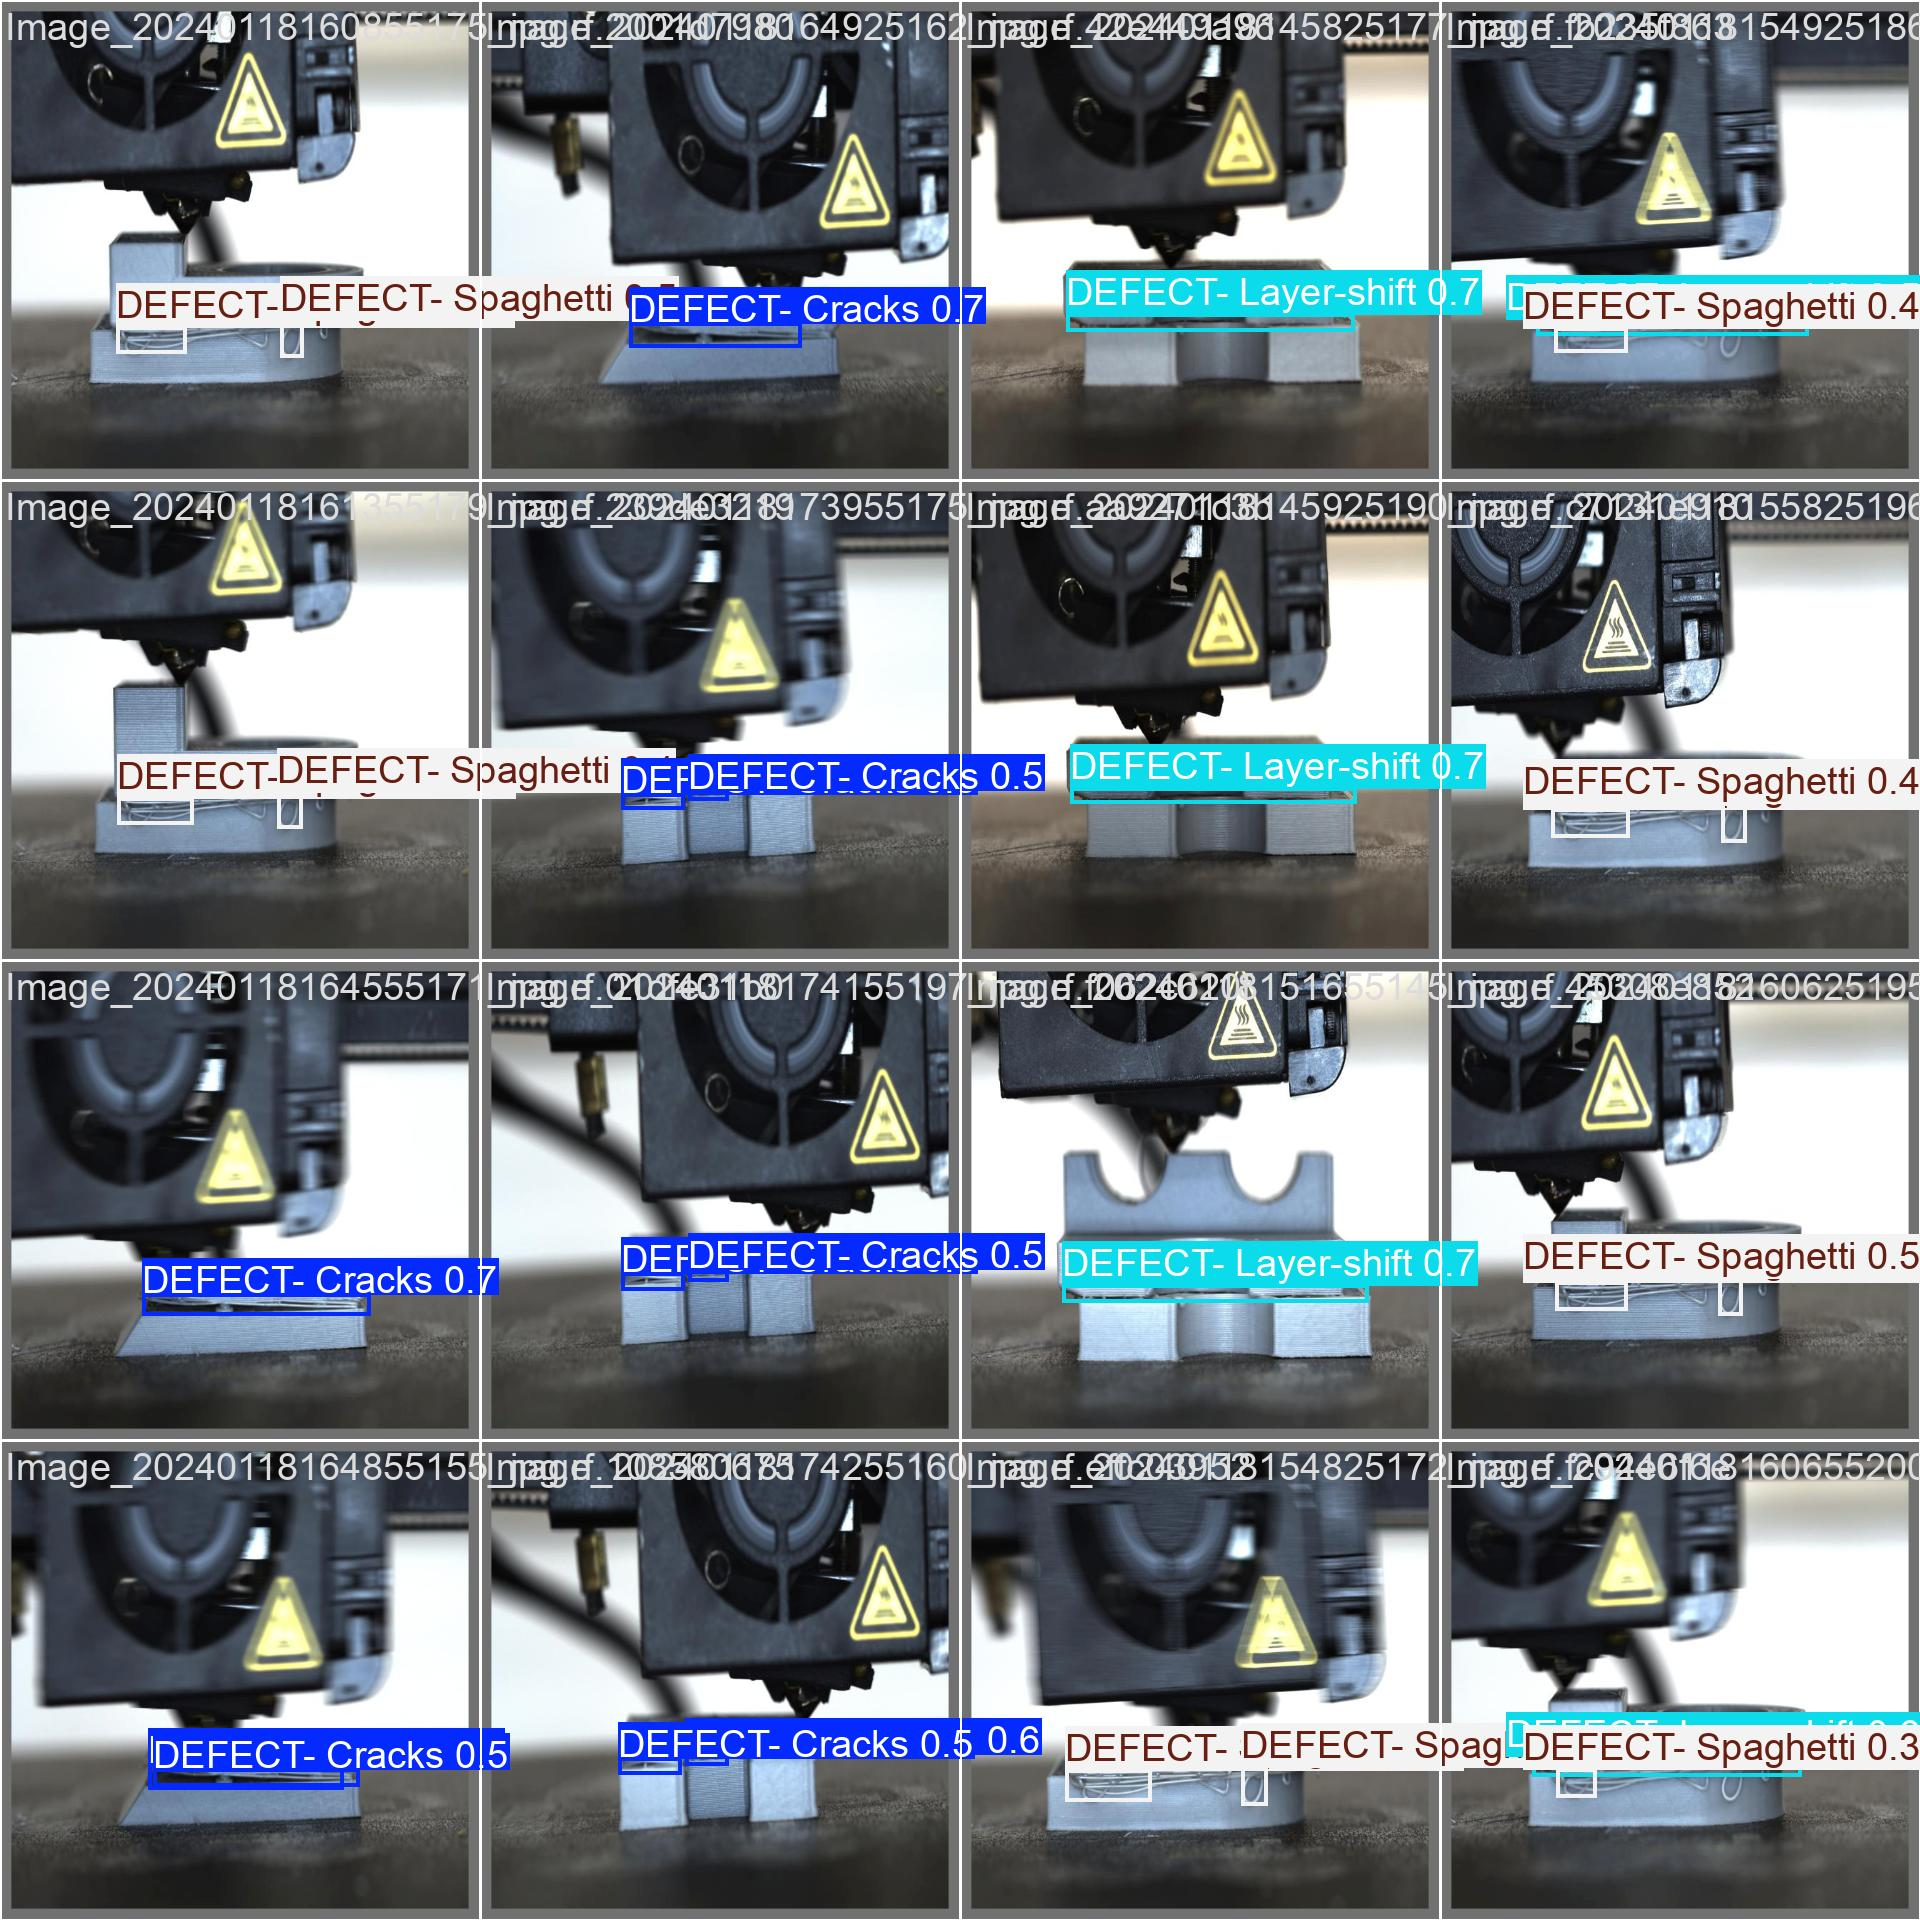

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

The command runs YOLO in *validation* mode (`mode=val`) for object detection (`task=detect`), using the best model weights (`best.pt`) from a previous training session. It validates the model on a dataset specified by the `data.yaml` file.



In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Project-11.2-2/valid/labels.cache... 843 images, 0 backgrounds, 0 corrupt: 100% 843/843 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 357, len(boxes) = 1089. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 53/53 [00:13<00:00,  3.99it/s]
                   all        843       1089      0.893      0.871      0.906       0.64
        DEFECT- Cracks         63         92      0.819      0.785       0.79      0.513
   DEFECT- Layer-shift        116        116      0.973      0.983      0.992      0.752
     DEFECT- Spaghetti        2

NOTE: The above output shows the performance of the YOLOv11s model after validation on our FDM printing unseen data. It achieved a high mean Average Precision (mAP) of 0.906, with the best results for "DEFECT- Layer-shift" (0.992). The model processed images with an average speed of 9.5ms per image.

#Once training is complete, the output will follow this hierarchical structure, and you can find the trained weight file at:  

**run > detect > train > weights > best.pt**  

Here, **best.pt** represents the best-performing model, while **last.pt** corresponds to the model from the final epoch.

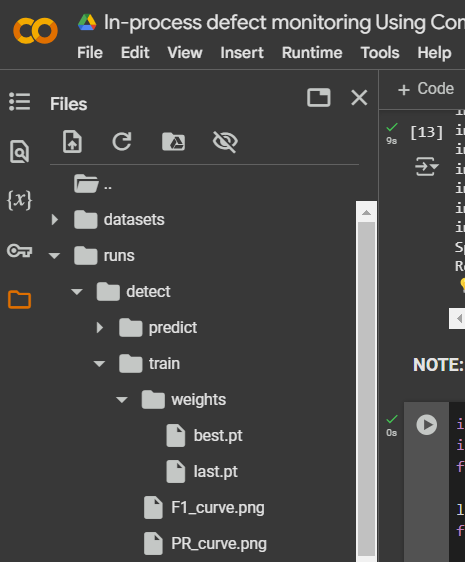


#The weight file(Best.pt) can be used for deploying the model locally on my PC, while the remaining charts and outputs will act as performance references. These will help in evaluating performance, comparing with other models, and tuning hyperparameters.